In [393]:
import quandl
import pandas_datareader as pdr

import pandas as pd
import yfinance as yf
import numpy as np
import mplfinance as mpf
from datetime import date

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import copy

from tqdm import tqdm

In [275]:
#First one is the Federal Funds Effective Rate
#Other are all cryptocurrencies which are available on FRED: Coinbase index, Bitcoin, Bitcoin Cash, Litecoin and Ethereum respectevly

FRED_INDICATORS = ['CBCCIND', 'CBBTCUSD', 'CBBCHUSD', 'CBLTCUSD', 'CBETHUSD', 'FEDFUNDS']

In [276]:
# update period for each ind (Y=Yearly, Q=Quarterly, M=Monthly, W=Weekly, D=Daily)
INDICATORS_PERIODS = {'CBCCIND': 'D', 'CBBTCUSD': 'D', 'CBBCHUSD': 'D', 'CBLTCUSD': 'D', 'CBETHUSD': 'D', 'FEDFUNDS': 'D'}                # 1. Growth

In [277]:
end = date.today()
start = date(year=end.year-5, month=end.month, day=end.day)
macro_indicators = dict()
tq_fred = tqdm(FRED_INDICATORS)

# get the stats from FRED database (with Pandas Datareader API)

tq_fred.set_description('Downloading stats from FRED:')
for indicator in tq_fred:

  # tq_fred.set_description(indicator)
  # macro_indicators[indicator] = pdr.DataReader(indicator, "fred", start=start, timeout=90)
  
 macro_indicators[indicator] = pdr.fred.FredReader(indicator, start=start, timeout=90).read()

In [278]:
macro_indicators['FEDFUNDS']

,FEDFUNDS
DATE,
2017-12-01,1.30
2018-01-01,1.41
2018-02-01,1.42
2018-03-01,1.51
2018-04-01,1.69
2018-05-01,1.70
2018-06-01,1.82
2018-07-01,1.91
2018-08-01,1.91


In [279]:
for i,value in enumerate(macro_indicators.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")



CBCCIND, CBBTCUSD, CBBCHUSD, CBLTCUSD, CBETHUSD, FEDFUNDS, 

In [280]:
macro_indicators['CBBTCUSD']

,CBBTCUSD
DATE,
2017-11-15,7294.00
2017-11-16,7838.53
2017-11-17,7714.71
2017-11-18,7777.01
2017-11-19,8031.82
...,...
2022-11-10,17573.15
2022-11-11,16997.14
2022-11-12,16777.73


In [281]:


macro_indicators['CBBTCUSD'].tail()

,CBBTCUSD
DATE,
2022-11-10,17573.15
2022-11-11,16997.14
2022-11-12,16777.73
2022-11-13,16290.62
2022-11-14,16576.49


<AxesSubplot:title={'center':'Fed funds rate over 5 years'}, xlabel='DATE'>

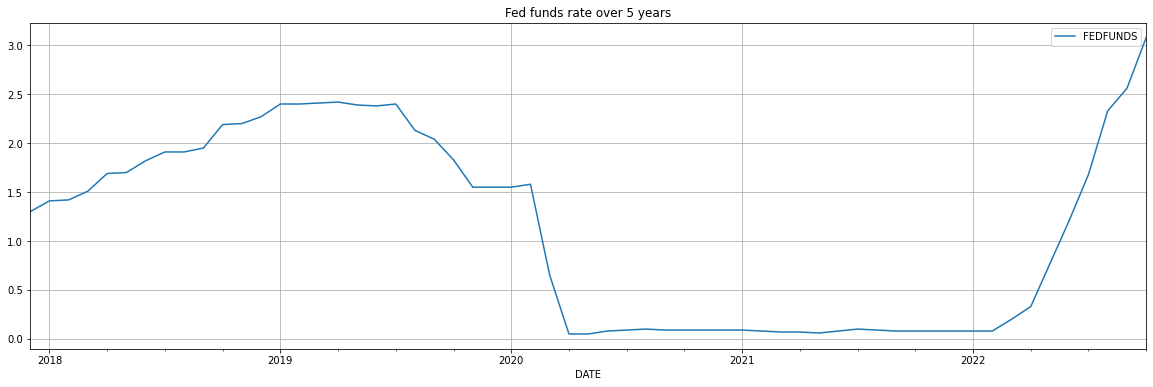

In [282]:
macro_indicators['FEDFUNDS'].plot.line(figsize=(20,6), grid = True, title='Fed funds rate over 5 years')

<AxesSubplot:title={'center':'Bitcoin price over 5 years'}, xlabel='DATE'>

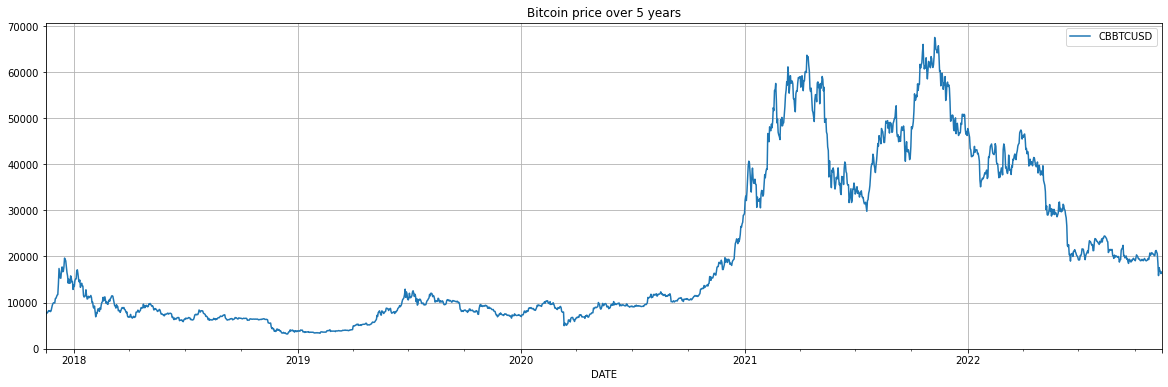

In [283]:
macro_indicators['CBBTCUSD'].plot.line(figsize=(20,6), grid = True, title='Bitcoin price over 5 years')

<AxesSubplot:title={'center':'Bitcoin cash price over 5 years'}, xlabel='DATE'>

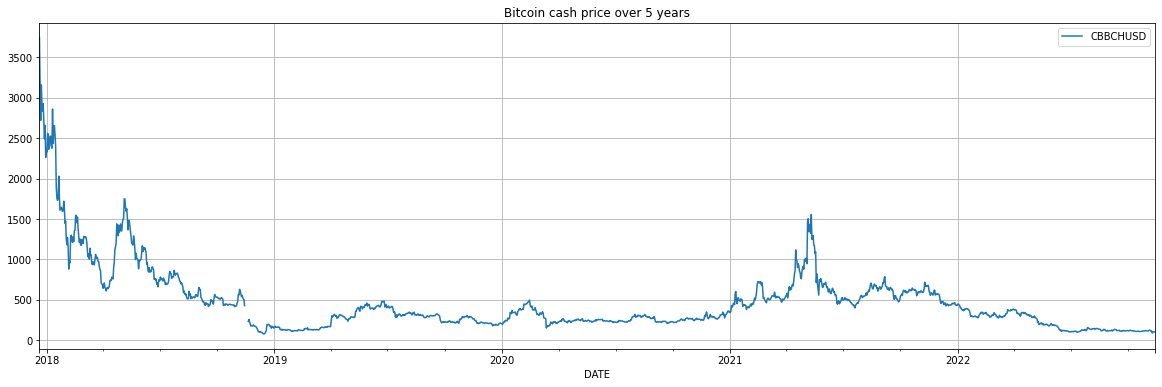

In [284]:
macro_indicators['CBBCHUSD'].plot.line(figsize=(20,6), grid = True, title='Bitcoin cash price over 5 years')

<AxesSubplot:title={'center':'Litecoin price over 5 years'}, xlabel='DATE'>

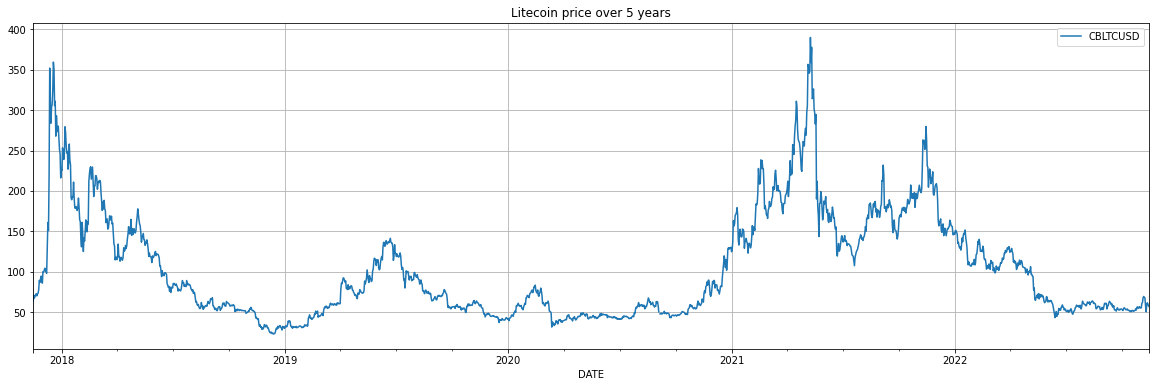

In [285]:
macro_indicators['CBLTCUSD'].plot.line(figsize=(20,6), grid = True, title='Litecoin price over 5 years')

<AxesSubplot:title={'center':'Etherium price over 5 years'}, xlabel='DATE'>

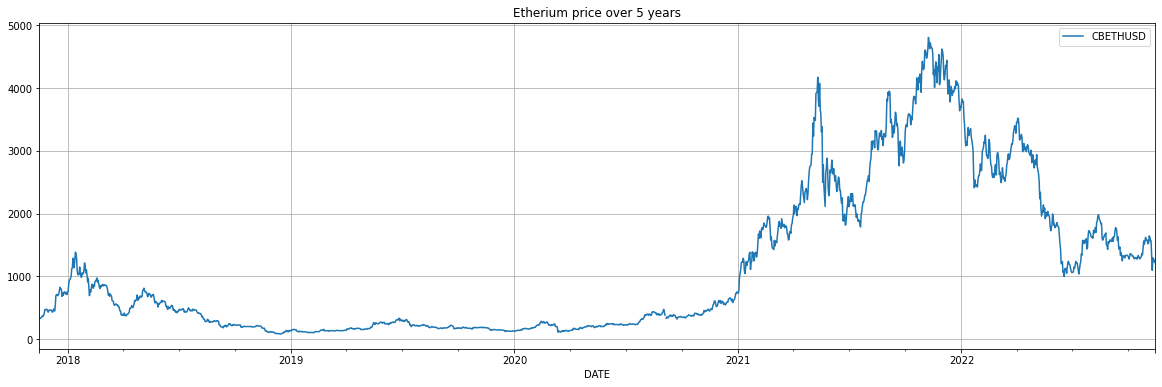

In [286]:
macro_indicators['CBETHUSD'].plot.line(figsize=(20,6), grid = True, title='Etherium price over 5 years')

In [287]:
macro_indicators.keys()

dict_keys(['CBCCIND', 'CBBTCUSD', 'CBBCHUSD', 'CBLTCUSD', 'CBETHUSD', 'FEDFUNDS'])

In [288]:
# Total indicators from FRED:
len(macro_indicators.keys())

6

In [289]:
# need to have a deep copy of macro indicators to make local transformations not changing the datarepo
macro_indicators_dict = copy.deepcopy(macro_indicators)

In [290]:
def get_macro_shift_transformation(macro_indicators_dict):
        """Add shifted (growth) values to the data_repo.macro_indicators before joining them together, remove non-stationary time series"""
        
        # Transform daily stats on this shift
        HISTORICAL_PERIODS_DAYS = [1, 3, 7, 30, 90, 365]
        
        # Different types of transformations for daily, weekly, monthly, indicators
        DoD_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'D']
        WoW_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'W']
        MoM_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'M']
        QoQ_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Q']
        YoY_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Y']


        for ind in DoD_ind:
            # transform blockchain_prices
            if not ind in {'CBCCIND', 'CBBTCUSD','CBBCHUSD','CBLTCUSD','CBETHUSD', 'FEDFUNDS'}:
                continue
            # treat those as an index
            for i in HISTORICAL_PERIODS_DAYS:
                df = macro_indicators_dict[ind]
                ind_transformed = ind + '_growth_' + str(i)+'d'
                df[ind_transformed] = df[ind]/df[ind].shift(i)-1

        # future growth stats
        for ind in ['CBCCIND', 'CBBTCUSD','CBBCHUSD','CBLTCUSD','CBETHUSD', 'FEDFUNDS']:
          for i in HISTORICAL_PERIODS_DAYS:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_future_growth_' + str(i)+'d'
            df[ind_transformed] = df[ind].shift(-i-1)/df[ind].shift(-1)-1

        for ind in WoW_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_wow'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(5)-1

        for ind in MoM_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(12)-1

        for ind in QoQ_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_qoq'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(4)-1


        for ind in YoY_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            macro_indicators_dict[ind].drop([ind], axis=1, inplace=True)

In [291]:
get_macro_shift_transformation(macro_indicators_dict)

In [292]:
# Daily
macro_indicators_dict['CBBTCUSD'].tail(1)

,CBBTCUSD,CBBTCUSD_growth_1d,CBBTCUSD_growth_3d,CBBTCUSD_growth_7d,CBBTCUSD_growth_30d,...,CBBTCUSD_future_growth_3d,CBBTCUSD_future_growth_7d,CBBTCUSD_future_growth_30d,CBBTCUSD_future_growth_90d,CBBTCUSD_future_growth_365d
DATE,,,,,,,,,,,
2022-11-14,16576.49,0.017548,-0.024748,-0.194486,-0.130957,...,NaN,NaN,NaN,NaN,NaN


In [293]:
macro_indicators_dict['CBBTCUSD'].tail(5)

,CBBTCUSD,CBBTCUSD_growth_1d,CBBTCUSD_growth_3d,CBBTCUSD_growth_7d,CBBTCUSD_growth_30d,...,CBBTCUSD_future_growth_3d,CBBTCUSD_future_growth_7d,CBBTCUSD_future_growth_30d,CBBTCUSD_future_growth_90d,CBBTCUSD_future_growth_365d
DATE,,,,,,,,,,,
2022-11-10,17573.15,0.108673,-0.146054,-0.130271,-0.078477,...,-0.024748,NaN,NaN,NaN,NaN
2022-11-11,16997.14,-0.032778,-0.084285,-0.196655,-0.112760,...,NaN,NaN,NaN,NaN,NaN
2022-11-12,16777.73,-0.012909,0.058490,-0.212488,-0.134389,...,NaN,NaN,NaN,NaN,NaN
2022-11-13,16290.62,-0.029033,-0.072982,-0.221004,-0.150984,...,NaN,NaN,NaN,NaN,NaN
2022-11-14,16576.49,0.017548,-0.024748,-0.194486,-0.130957,...,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='DATE'>

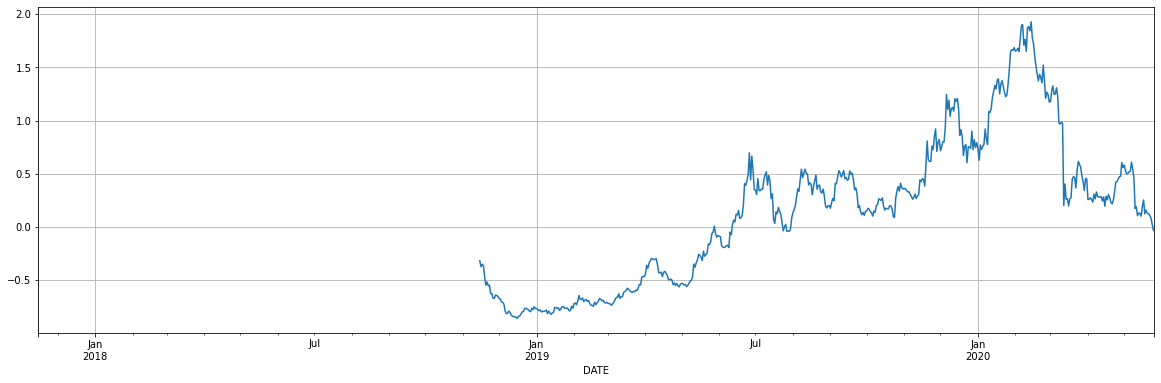

In [294]:
macro_indicators_dict['CBCCIND']['CBCCIND_growth_365d'].plot.line(figsize=(20,6), grid = True)

<AxesSubplot:xlabel='DATE'>

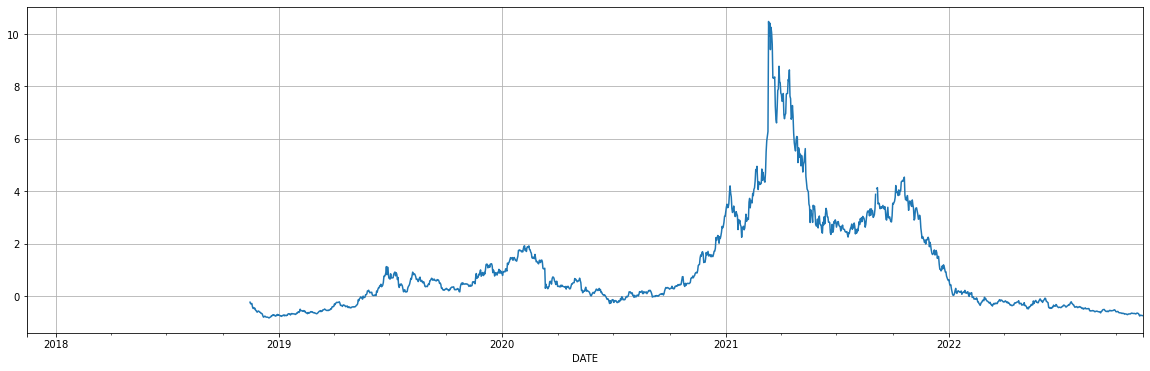

In [295]:
macro_indicators_dict['CBBTCUSD']['CBBTCUSD_growth_365d'].plot.line(figsize=(20,6), grid = True)

<AxesSubplot:xlabel='DATE'>

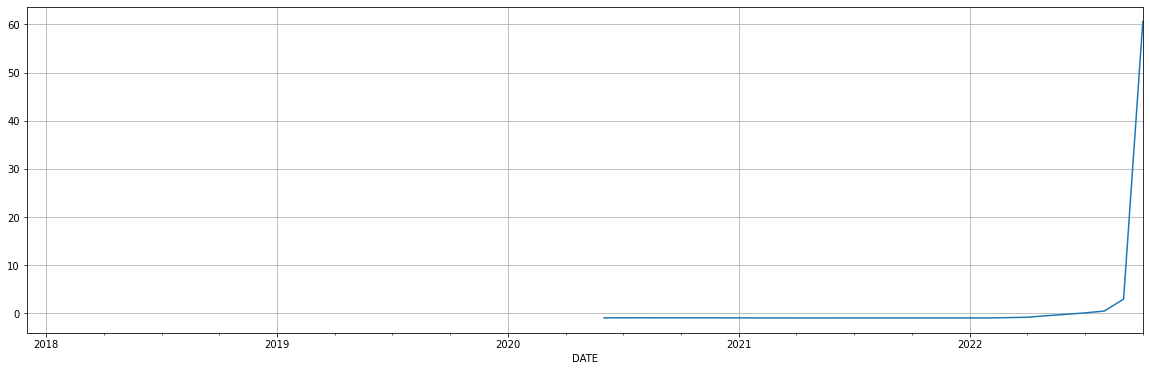

In [296]:
macro_indicators_dict['FEDFUNDS']['FEDFUNDS_growth_30d'].plot.line(figsize=(20,6), grid = True)

In [297]:
macro_indicators_dict['FEDFUNDS'].tail(5)

,FEDFUNDS,FEDFUNDS_growth_1d,FEDFUNDS_growth_3d,FEDFUNDS_growth_7d,FEDFUNDS_growth_30d,...,FEDFUNDS_future_growth_3d,FEDFUNDS_future_growth_7d,FEDFUNDS_future_growth_30d,FEDFUNDS_future_growth_90d,FEDFUNDS_future_growth_365d
DATE,,,,,,,,,,,
2022-06-01,1.21,0.571429,5.050000,14.125,-0.219355,...,0.833333,NaN,NaN,NaN,NaN
2022-07-01,1.68,0.388430,4.090909,20.000,0.083871,...,NaN,NaN,NaN,NaN,NaN
2022-08-01,2.33,0.386905,2.025974,28.125,0.474684,...,NaN,NaN,NaN,NaN,NaN
2022-09-01,2.56,0.098712,1.115702,31.000,2.938462,...,NaN,NaN,NaN,NaN,NaN
2022-10-01,3.08,0.203125,0.833333,14.400,60.600000,...,NaN,NaN,NaN,NaN,NaN


In [298]:
macro_indicators_dict['CBBTCUSD'].tail(5)

,CBBTCUSD,CBBTCUSD_growth_1d,CBBTCUSD_growth_3d,CBBTCUSD_growth_7d,CBBTCUSD_growth_30d,...,CBBTCUSD_future_growth_3d,CBBTCUSD_future_growth_7d,CBBTCUSD_future_growth_30d,CBBTCUSD_future_growth_90d,CBBTCUSD_future_growth_365d
DATE,,,,,,,,,,,
2022-11-10,17573.15,0.108673,-0.146054,-0.130271,-0.078477,...,-0.024748,NaN,NaN,NaN,NaN
2022-11-11,16997.14,-0.032778,-0.084285,-0.196655,-0.112760,...,NaN,NaN,NaN,NaN,NaN
2022-11-12,16777.73,-0.012909,0.058490,-0.212488,-0.134389,...,NaN,NaN,NaN,NaN,NaN
2022-11-13,16290.62,-0.029033,-0.072982,-0.221004,-0.150984,...,NaN,NaN,NaN,NaN,NaN
2022-11-14,16576.49,0.017548,-0.024748,-0.194486,-0.130957,...,NaN,NaN,NaN,NaN,NaN


In [299]:
for i,value in enumerate(macro_indicators_dict.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")



CBCCIND, CBBTCUSD, CBBCHUSD, CBLTCUSD, CBETHUSD, FEDFUNDS, 

In [300]:
#Smart-joining using pandas

dates = pd.DataFrame(macro_indicators_dict['CBCCIND'].index.sort_values().unique(), columns=['DATE'])
dates

,DATE
0,2017-11-15
1,2017-11-16
2,2017-11-17
3,2017-11-18
4,2017-11-19
...,...
919,2020-05-22
920,2020-05-23
921,2020-05-24
922,2020-05-25


In [301]:
def get_daily_macro_stats_df(daily_df, macro_ind_df, regime='LAST'):
        """take Time from daily_df, and apply that to macro_ind_df, (LAST=take last observation, PREVIOUS=take previous) """
        ticker_dates = daily_df.DATE.sort_values().unique()
        new_column_dict = {}

        for elem in ticker_dates:
            ts = pd.to_datetime(str(elem))
            d = ts.strftime('%Y-%m-%d')
            # all potential records to merge
            options_to_merge = macro_ind_df[macro_ind_df.index <= d]
            if len(options_to_merge) == 0:
                continue
            last_value = options_to_merge.tail(1).values.tolist()[0]
            prev_value = options_to_merge.tail(2).values.tolist()[0]
            if regime == 'PREVIOUS':
                if prev_value is not None:
                    new_column_dict[d] = prev_value
            elif regime == 'LAST':
                if last_value is not None:
                    new_column_dict[d] = last_value
            else:
                raise("Regime should be in ('PREVIOUS','LAST')")
        return pd.DataFrame.from_dict(new_column_dict, orient='index', columns = options_to_merge.keys())

In [302]:
# 2) Create a DAILY stats dataset
# Depending on daily, weekly, etc we have different joins
  # join on the last available date
lastday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v not in ('M', 'Q', 'Y')]
  # join on the previous available date (M,Q,Y stats write say '2021-01-01' - but they represent the whole M,Q,Y STARTING at this date)
firstday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v in ('M', 'Q', 'Y')]

  # start from all dates we need to have macro stats
dates = pd.DataFrame(macro_indicators_dict['CBCCIND'].index.sort_values().unique(), columns=['DATE'])

macro_data_df = None
#  iterate over all transformed series in self.macro_indicators_dict and join one by one
# all non-Monthly indicators are
tq_last_day = tqdm(lastday_ind)
tq_last_day.set_description("Merging LAST Day indicators")
for ind in tq_last_day:
  # do not add some indicators to the final dataset (they are duplicated in another datasource)
  if ind in (''):
    continue
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='LAST')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

tq_first_day = tqdm(firstday_ind)
tq_first_day.set_description("Merging FIRST Day indicators")
#  some stats  have first day of period date (e.g. '2020-06-01' instead of '2020-06-30'), so we need to get PREVIOUS available macro param
for ind in tq_first_day:
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='PREVIOUS')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

Merging LAST Day indicators: 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
Merging FIRST Day indicators: : 0it [00:00, ?it/s]


In [303]:
macro_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 924 entries, 2017-11-15 to 2020-05-26
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CBCCIND                      924 non-null    float64
 1   CBCCIND_growth_1d            923 non-null    float64
 2   CBCCIND_growth_3d            921 non-null    float64
 3   CBCCIND_growth_7d            917 non-null    float64
 4   CBCCIND_growth_30d           894 non-null    float64
 5   CBCCIND_growth_90d           834 non-null    float64
 6   CBCCIND_growth_365d          559 non-null    float64
 7   CBCCIND_future_growth_1d     922 non-null    float64
 8   CBCCIND_future_growth_3d     920 non-null    float64
 9   CBCCIND_future_growth_7d     916 non-null    float64
 10  CBCCIND_future_growth_30d    893 non-null    float64
 11  CBCCIND_future_growth_90d    833 non-null    float64
 12  CBCCIND_future_growth_365d   558 non-null    float64
 13  CBBTCUSD 

In [304]:
# SAVING A DATAFRAME WITH PARQUET 
macro_data_df.to_parquet('macro_df_small.parquet',compression='BROTLI')

In [305]:
macro_df = pd.read_parquet('macro_df_small.parquet')

In [306]:
len(macro_df.keys())

78

In [307]:
macro_df

,CBCCIND,CBCCIND_growth_1d,CBCCIND_growth_3d,CBCCIND_growth_7d,CBCCIND_growth_30d,...,FEDFUNDS_future_growth_3d,FEDFUNDS_future_growth_7d,FEDFUNDS_future_growth_30d,FEDFUNDS_future_growth_90d,FEDFUNDS_future_growth_365d
2017-11-15,3070.122647,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2017-11-16,3295.415280,0.073382,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2017-11-17,3194.552143,-0.030607,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2017-11-18,3270.932225,0.023909,0.065408,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2017-11-19,3387.873070,0.035752,0.028056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22,3293.095658,0.016658,-0.058290,-0.004528,0.256208,...,0.125,0.125,NaN,NaN,NaN
2020-05-23,3295.101293,0.000609,-0.031294,-0.014144,0.204999,...,0.125,0.125,NaN,NaN,NaN
2020-05-24,3135.639575,-0.048394,-0.031952,-0.089898,0.140774,...,0.125,0.125,NaN,NaN,NaN
2020-05-25,3203.959113,0.021788,-0.027068,-0.079413,0.156011,...,0.125,0.125,NaN,NaN,NaN


In [308]:
len(macro_df.keys())

78

In [309]:
i=1
for value in macro_df.keys():
  if not ('future' in value):
    print(value, end =", ")
    if i%8==0:
      print('\n')
    i+=1

CBCCIND, CBCCIND_growth_1d, CBCCIND_growth_3d, CBCCIND_growth_7d, CBCCIND_growth_30d, CBCCIND_growth_90d, CBCCIND_growth_365d, CBBTCUSD, 

CBBTCUSD_growth_1d, CBBTCUSD_growth_3d, CBBTCUSD_growth_7d, CBBTCUSD_growth_30d, CBBTCUSD_growth_90d, CBBTCUSD_growth_365d, CBBCHUSD, CBBCHUSD_growth_1d, 

CBBCHUSD_growth_3d, CBBCHUSD_growth_7d, CBBCHUSD_growth_30d, CBBCHUSD_growth_90d, CBBCHUSD_growth_365d, CBLTCUSD, CBLTCUSD_growth_1d, CBLTCUSD_growth_3d, 

CBLTCUSD_growth_7d, CBLTCUSD_growth_30d, CBLTCUSD_growth_90d, CBLTCUSD_growth_365d, CBETHUSD, CBETHUSD_growth_1d, CBETHUSD_growth_3d, CBETHUSD_growth_7d, 

CBETHUSD_growth_30d, CBETHUSD_growth_90d, CBETHUSD_growth_365d, FEDFUNDS, FEDFUNDS_growth_1d, FEDFUNDS_growth_3d, FEDFUNDS_growth_7d, FEDFUNDS_growth_30d, 

FEDFUNDS_growth_90d, FEDFUNDS_growth_365d, 

In [310]:
pd.set_option('display.max_columns', 10)
macro_df.tail(1)
# pd.set_option('display.max_columns', None)

,CBCCIND,CBCCIND_growth_1d,CBCCIND_growth_3d,CBCCIND_growth_7d,CBCCIND_growth_30d,...,FEDFUNDS_future_growth_3d,FEDFUNDS_future_growth_7d,FEDFUNDS_future_growth_30d,FEDFUNDS_future_growth_90d,FEDFUNDS_future_growth_365d
2020-05-26,3180.272971,-0.007393,-0.034848,-0.090553,0.123868,...,0.125,0.125,NaN,NaN,NaN


In [311]:
macro_df.tail(100)

,CBCCIND,CBCCIND_growth_1d,CBCCIND_growth_3d,CBCCIND_growth_7d,CBCCIND_growth_30d,...,FEDFUNDS_future_growth_3d,FEDFUNDS_future_growth_7d,FEDFUNDS_future_growth_30d,FEDFUNDS_future_growth_90d,FEDFUNDS_future_growth_365d
2020-02-17,3608.304194,-0.010888,-0.073742,0.010409,0.132339,...,-0.876923,-0.861538,2.938462,NaN,NaN
2020-02-18,3779.194504,0.047360,0.019368,-0.009357,0.230379,...,-0.876923,-0.861538,2.938462,NaN,NaN
2020-02-19,3581.975497,-0.052185,-0.018105,-0.076470,0.170119,...,-0.876923,-0.861538,2.938462,NaN,NaN
2020-02-20,3558.590653,-0.006528,-0.013778,-0.067546,0.147125,...,-0.876923,-0.861538,2.938462,NaN,NaN
2020-02-21,3614.554799,0.015726,-0.043565,-0.072137,0.176935,...,-0.876923,-0.861538,2.938462,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22,3293.095658,0.016658,-0.058290,-0.004528,0.256208,...,0.125000,0.125000,NaN,NaN,NaN
2020-05-23,3295.101293,0.000609,-0.031294,-0.014144,0.204999,...,0.125000,0.125000,NaN,NaN,NaN
2020-05-24,3135.639575,-0.048394,-0.031952,-0.089898,0.140774,...,0.125000,0.125000,NaN,NaN,NaN
2020-05-25,3203.959113,0.021788,-0.027068,-0.079413,0.156011,...,0.125000,0.125000,NaN,NaN,NaN


In [312]:
macro_indicators_dict['CBBTCUSD']

,CBBTCUSD,CBBTCUSD_growth_1d,CBBTCUSD_growth_3d,CBBTCUSD_growth_7d,CBBTCUSD_growth_30d,...,CBBTCUSD_future_growth_3d,CBBTCUSD_future_growth_7d,CBBTCUSD_future_growth_30d,CBBTCUSD_future_growth_90d,CBBTCUSD_future_growth_365d
DATE,,,,,,,,,,,
2017-11-15,7294.00,NaN,NaN,NaN,NaN,...,0.024659,0.024575,1.506849,0.208515,-0.296776
2017-11-16,7838.53,0.074655,NaN,NaN,NaN,...,0.070165,0.064850,1.511953,0.300273,-0.286536
2017-11-17,7714.71,-0.015796,NaN,NaN,NaN,...,0.042689,0.130962,1.448114,0.307378,-0.285072
2017-11-18,7777.01,0.008075,0.066220,NaN,NaN,...,0.027164,0.170483,1.221007,0.384680,-0.410657
2017-11-19,8031.82,0.032765,0.024659,NaN,NaN,...,-0.027235,0.183224,0.998167,0.257271,-0.473204
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-10,17573.15,0.108673,-0.146054,-0.130271,-0.078477,...,-0.024748,NaN,NaN,NaN,NaN
2022-11-11,16997.14,-0.032778,-0.084285,-0.196655,-0.112760,...,NaN,NaN,NaN,NaN,NaN
2022-11-12,16777.73,-0.012909,0.058490,-0.212488,-0.134389,...,NaN,NaN,NaN,NaN,NaN


In [313]:
macro_indicators_dict['FEDFUNDS']


,FEDFUNDS,FEDFUNDS_growth_1d,FEDFUNDS_growth_3d,FEDFUNDS_growth_7d,FEDFUNDS_growth_30d,...,FEDFUNDS_future_growth_3d,FEDFUNDS_future_growth_7d,FEDFUNDS_future_growth_30d,FEDFUNDS_future_growth_90d,FEDFUNDS_future_growth_365d
DATE,,,,,,,,,,,
2017-12-01,1.30,NaN,NaN,NaN,NaN,...,0.198582,0.354610,-0.936170,NaN,NaN
2018-01-01,1.41,0.084615,NaN,NaN,NaN,...,0.197183,0.373239,-0.929577,NaN,NaN
2018-02-01,1.42,0.007092,NaN,NaN,NaN,...,0.205298,0.450331,-0.940397,NaN,NaN
2018-03-01,1.51,0.063380,0.161538,NaN,NaN,...,0.130178,0.301775,-0.946746,NaN,NaN
2018-04-01,1.69,0.119205,0.198582,NaN,NaN,...,0.123529,0.335294,-0.947059,NaN,NaN
2018-05-01,1.70,0.005917,0.197183,NaN,NaN,...,0.071429,0.318681,-0.950549,NaN,NaN
2018-06-01,1.82,0.070588,0.205298,NaN,NaN,...,0.146597,0.256545,-0.952880,NaN,NaN
2018-07-01,1.91,0.049451,0.130178,0.469231,NaN,...,0.151832,0.261780,-0.958115,NaN,NaN
2018-08-01,1.91,0.000000,0.123529,0.354610,NaN,...,0.164103,0.241026,-0.964103,NaN,NaN


In [314]:
macro_df['CBBTCUSD']

2017-11-15    7294.00
2017-11-16    7838.53
2017-11-17    7714.71
2017-11-18    7777.01
2017-11-19    8031.82
               ...   
2020-05-22    9173.23
2020-05-23    9166.02
2020-05-24    8673.64
2020-05-25    8892.39
2020-05-26    8836.77
Name: CBBTCUSD, Length: 924, dtype: float64

In [315]:
macro_df.tail(1)

,CBCCIND,CBCCIND_growth_1d,CBCCIND_growth_3d,CBCCIND_growth_7d,CBCCIND_growth_30d,...,FEDFUNDS_future_growth_3d,FEDFUNDS_future_growth_7d,FEDFUNDS_future_growth_30d,FEDFUNDS_future_growth_90d,FEDFUNDS_future_growth_365d
2020-05-26,3180.272971,-0.007393,-0.034848,-0.090553,0.123868,...,0.125,0.125,NaN,NaN,NaN


In [316]:
macro_df.corr()

,CBCCIND,CBCCIND_growth_1d,CBCCIND_growth_3d,CBCCIND_growth_7d,CBCCIND_growth_30d,...,FEDFUNDS_future_growth_3d,FEDFUNDS_future_growth_7d,FEDFUNDS_future_growth_30d,FEDFUNDS_future_growth_90d,FEDFUNDS_future_growth_365d
CBCCIND,1.000000,0.066880,0.114993,0.183261,0.344350,...,0.054247,0.186751,-0.090126,NaN,NaN
CBCCIND_growth_1d,0.066880,1.000000,0.573681,0.406437,0.120073,...,-0.000007,-0.004853,-0.022030,NaN,NaN
CBCCIND_growth_3d,0.114993,0.573681,1.000000,0.683604,0.219250,...,-0.007203,-0.015508,-0.061433,NaN,NaN
CBCCIND_growth_7d,0.183261,0.406437,0.683604,1.000000,0.385149,...,-0.028850,-0.029374,-0.093919,NaN,NaN
CBCCIND_growth_30d,0.344350,0.120073,0.219250,0.385149,1.000000,...,-0.153829,-0.113698,-0.209161,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
FEDFUNDS_future_growth_3d,0.054247,-0.000007,-0.007203,-0.028850,-0.153829,...,1.000000,0.835904,0.406741,NaN,NaN
FEDFUNDS_future_growth_7d,0.186751,-0.004853,-0.015508,-0.029374,-0.113698,...,0.835904,1.000000,0.330349,NaN,NaN
FEDFUNDS_future_growth_30d,-0.090126,-0.022030,-0.061433,-0.093919,-0.209161,...,0.406741,0.330349,1.000000,NaN,NaN
FEDFUNDS_future_growth_90d,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [317]:
CBBTCUSD_growth_365d_corr = pd.DataFrame(macro_df.corr()['CBBTCUSD_growth_365d'].sort_values())

In [318]:
CBCCIND_growth_365d_corr = pd.DataFrame(macro_df.corr()['CBCCIND_growth_365d'].sort_values())

In [319]:
CBBTCUSD_growth_365d_corr.head()

,CBBTCUSD_growth_365d
CBLTCUSD_future_growth_90d,-0.745402
CBCCIND_future_growth_365d,-0.675662
CBCCIND_future_growth_90d,-0.621874
FEDFUNDS_growth_7d,-0.613902
CBBCHUSD_future_growth_90d,-0.590461


In [320]:
CBBTCUSD_growth_365d_corr.tail()

,CBBTCUSD_growth_365d
FEDFUNDS_growth_30d,NaN
FEDFUNDS_growth_90d,NaN
FEDFUNDS_growth_365d,NaN
FEDFUNDS_future_growth_90d,NaN
FEDFUNDS_future_growth_365d,NaN


<AxesSubplot:>

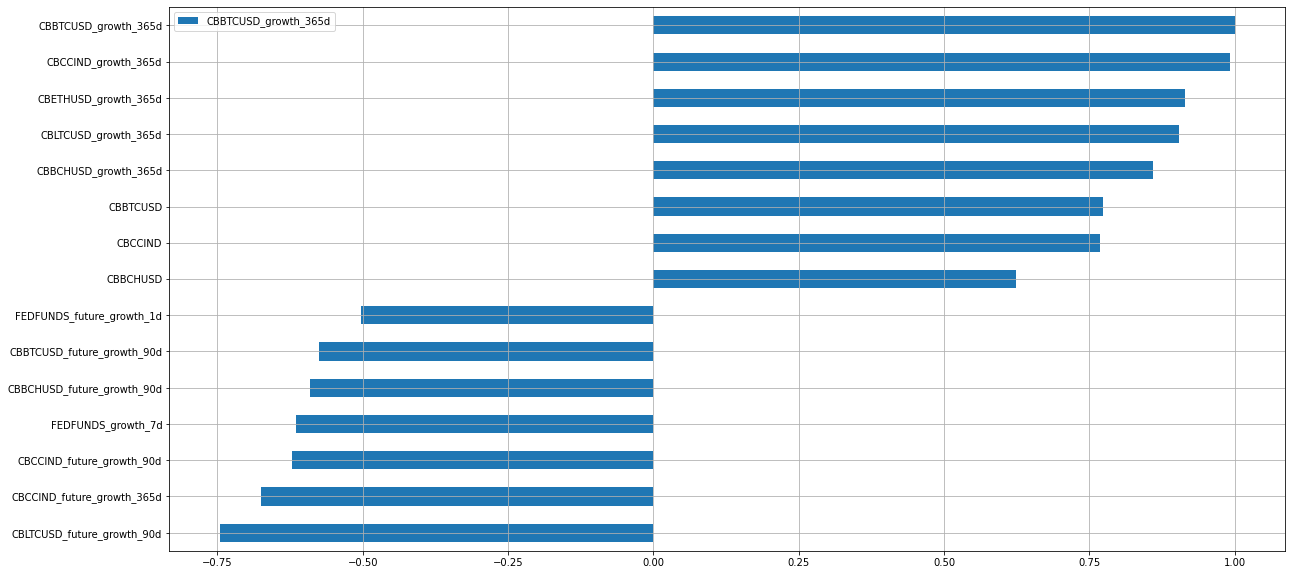

In [329]:
filter = np.abs(CBBTCUSD_growth_365d_corr.CBBTCUSD_growth_365d)>=0.5
CBBTCUSD_growth_365d_corr[filter].plot.barh(figsize=(20,10), grid=True)

<AxesSubplot:>

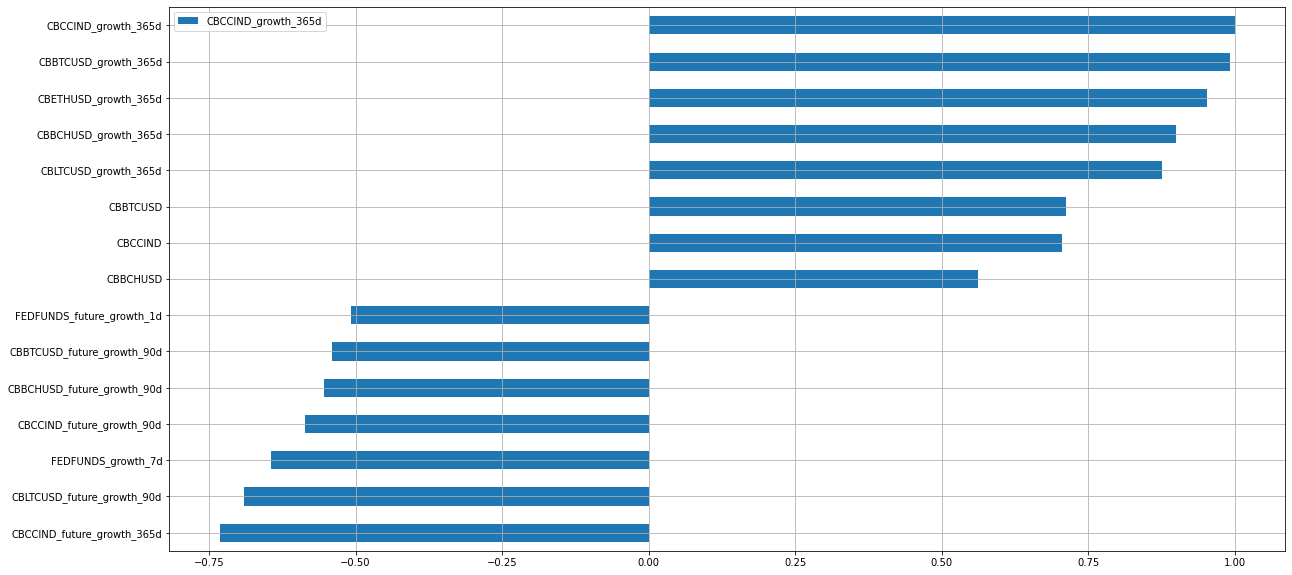

In [322]:
filter = np.abs(CBCCIND_growth_365d_corr.CBCCIND_growth_365d)>=0.5
CBCCIND_growth_365d_corr[filter].plot.barh(figsize=(20,10), grid=True)

In [323]:
macro_df.corr()['CBBTCUSD_growth_365d'].sort_values()

CBLTCUSD_future_growth_90d    -0.745402
CBCCIND_future_growth_365d    -0.675662
CBCCIND_future_growth_90d     -0.621874
FEDFUNDS_growth_7d            -0.613902
CBBCHUSD_future_growth_90d    -0.590461
                                 ...   
FEDFUNDS_growth_30d                 NaN
FEDFUNDS_growth_90d                 NaN
FEDFUNDS_growth_365d                NaN
FEDFUNDS_future_growth_90d          NaN
FEDFUNDS_future_growth_365d         NaN
Name: CBBTCUSD_growth_365d, Length: 78, dtype: float64

In [324]:
macro_df.corr()['CBBCHUSD_growth_365d'].sort_values()

CBCCIND_future_growth_365d    -0.701026
FEDFUNDS_future_growth_1d     -0.632108
FEDFUNDS_growth_7d            -0.470163
CBLTCUSD_future_growth_90d    -0.432934
CBBCHUSD_future_growth_90d    -0.426734
                                 ...   
FEDFUNDS_growth_30d                 NaN
FEDFUNDS_growth_90d                 NaN
FEDFUNDS_growth_365d                NaN
FEDFUNDS_future_growth_90d          NaN
FEDFUNDS_future_growth_365d         NaN
Name: CBBCHUSD_growth_365d, Length: 78, dtype: float64

In [325]:
macro_df.corr()['CBLTCUSD_growth_365d'].sort_values()

CBLTCUSD_future_growth_90d    -0.756510
CBCCIND_future_growth_365d    -0.729921
FEDFUNDS_future_growth_3d     -0.627724
CBCCIND_future_growth_90d     -0.619158
FEDFUNDS_future_growth_7d     -0.607105
                                 ...   
FEDFUNDS_growth_30d                 NaN
FEDFUNDS_growth_90d                 NaN
FEDFUNDS_growth_365d                NaN
FEDFUNDS_future_growth_90d          NaN
FEDFUNDS_future_growth_365d         NaN
Name: CBLTCUSD_growth_365d, Length: 78, dtype: float64

In [326]:
macro_df.corr()['CBETHUSD_growth_365d'].sort_values()

CBCCIND_future_growth_365d    -0.753913
FEDFUNDS_growth_7d            -0.712558
FEDFUNDS                      -0.598104
CBLTCUSD_future_growth_90d    -0.552412
CBCCIND_future_growth_90d     -0.490962
                                 ...   
FEDFUNDS_growth_30d                 NaN
FEDFUNDS_growth_90d                 NaN
FEDFUNDS_growth_365d                NaN
FEDFUNDS_future_growth_90d          NaN
FEDFUNDS_future_growth_365d         NaN
Name: CBETHUSD_growth_365d, Length: 78, dtype: float64

In [337]:
macro_df.corr()['FEDFUNDS'].sort_values()

CBETHUSD_future_growth_365d   -0.764304
CBLTCUSD_future_growth_365d   -0.716853
CBBTCUSD_future_growth_365d   -0.632739
CBETHUSD_growth_365d          -0.598104
FEDFUNDS_future_growth_30d    -0.574198
                                 ...   
FEDFUNDS_growth_30d                 NaN
FEDFUNDS_growth_90d                 NaN
FEDFUNDS_growth_365d                NaN
FEDFUNDS_future_growth_90d          NaN
FEDFUNDS_future_growth_365d         NaN
Name: FEDFUNDS, Length: 78, dtype: float64

In [338]:
# Future growth indicators are mostly correlated with each other
future_ind = []
for ind in macro_df.keys():
  if 'future' in ind:
    future_ind.append(ind)
  
print(future_ind)

['CBCCIND_future_growth_1d', 'CBCCIND_future_growth_3d', 'CBCCIND_future_growth_7d', 'CBCCIND_future_growth_30d', 'CBCCIND_future_growth_90d', 'CBCCIND_future_growth_365d', 'CBBTCUSD_future_growth_1d', 'CBBTCUSD_future_growth_3d', 'CBBTCUSD_future_growth_7d', 'CBBTCUSD_future_growth_30d', 'CBBTCUSD_future_growth_90d', 'CBBTCUSD_future_growth_365d', 'CBBCHUSD_future_growth_1d', 'CBBCHUSD_future_growth_3d', 'CBBCHUSD_future_growth_7d', 'CBBCHUSD_future_growth_30d', 'CBBCHUSD_future_growth_90d', 'CBBCHUSD_future_growth_365d', 'CBLTCUSD_future_growth_1d', 'CBLTCUSD_future_growth_3d', 'CBLTCUSD_future_growth_7d', 'CBLTCUSD_future_growth_30d', 'CBLTCUSD_future_growth_90d', 'CBLTCUSD_future_growth_365d', 'CBETHUSD_future_growth_1d', 'CBETHUSD_future_growth_3d', 'CBETHUSD_future_growth_7d', 'CBETHUSD_future_growth_30d', 'CBETHUSD_future_growth_90d', 'CBETHUSD_future_growth_365d', 'FEDFUNDS_future_growth_1d', 'FEDFUNDS_future_growth_3d', 'FEDFUNDS_future_growth_7d', 'FEDFUNDS_future_growth_30d'

In [339]:
# include all features 
macro_df_no_future_ind = macro_df.keys()
# do not use future_ind in the list to find correlations with the label (which is a future_indicator)
macro_df_no_future_ind = macro_df_no_future_ind.drop(future_ind)

In [340]:
macro_df.corr()['CBCCIND_future_growth_365d'][macro_df_no_future_ind].sort_values()

CBCCIND                -0.860644
CBBTCUSD               -0.832947
CBETHUSD               -0.807507
CBLTCUSD               -0.805454
CBBCHUSD               -0.792949
CBETHUSD_growth_365d   -0.753913
CBCCIND_growth_365d    -0.731269
CBLTCUSD_growth_365d   -0.729921
CBBCHUSD_growth_365d   -0.701026
CBBTCUSD_growth_365d   -0.675662
FEDFUNDS_growth_3d     -0.371370
FEDFUNDS_growth_1d     -0.327664
CBETHUSD_growth_30d    -0.281247
CBETHUSD_growth_90d    -0.252189
CBBCHUSD_growth_90d    -0.221863
FEDFUNDS_growth_7d     -0.197023
CBCCIND_growth_90d     -0.177636
CBLTCUSD_growth_30d    -0.173511
CBCCIND_growth_30d     -0.172320
CBBTCUSD_growth_90d    -0.167031
CBETHUSD_growth_7d     -0.157293
CBBTCUSD_growth_30d    -0.138718
CBLTCUSD_growth_90d    -0.136611
CBCCIND_growth_7d      -0.120878
CBETHUSD_growth_3d     -0.106922
CBBTCUSD_growth_7d     -0.105325
CBLTCUSD_growth_7d     -0.101605
CBCCIND_growth_3d      -0.079380
CBBTCUSD_growth_3d     -0.067439
CBLTCUSD_growth_3d     -0.062893
CBETHUSD_g

In [341]:
macro_df.corr()['CBCCIND_future_growth_90d'][macro_df_no_future_ind].sort_values()

CBBTCUSD_growth_365d   -0.621874
CBLTCUSD_growth_365d   -0.619158
CBCCIND_growth_365d    -0.585600
CBBTCUSD               -0.577679
CBCCIND                -0.568454
CBETHUSD_growth_365d   -0.490962
CBBCHUSD               -0.456829
CBETHUSD               -0.414941
CBBCHUSD_growth_365d   -0.398264
CBLTCUSD               -0.363409
FEDFUNDS_growth_1d     -0.166550
FEDFUNDS_growth_3d     -0.075337
CBBTCUSD_growth_90d    -0.005598
CBETHUSD_growth_7d      0.001686
CBETHUSD_growth_3d      0.003478
CBETHUSD_growth_1d      0.005041
CBETHUSD_growth_30d     0.013399
CBCCIND_growth_1d       0.028883
CBBTCUSD_growth_1d      0.029230
CBLTCUSD_growth_1d      0.037606
CBBTCUSD_growth_3d      0.044702
CBBTCUSD_growth_30d     0.045751
CBCCIND_growth_3d       0.046018
CBBTCUSD_growth_7d      0.049280
CBCCIND_growth_7d       0.051118
CBLTCUSD_growth_7d      0.051136
CBBCHUSD_growth_1d      0.051364
CBLTCUSD_growth_3d      0.055190
CBCCIND_growth_30d      0.062170
CBCCIND_growth_90d      0.068429
CBBCHUSD_g

In [342]:
macro_df.corr()['CBCCIND_future_growth_30d'][macro_df_no_future_ind].sort_values()

CBBCHUSD               -0.387720
CBLTCUSD_growth_365d   -0.378516
CBETHUSD_growth_365d   -0.365693
CBBTCUSD_growth_365d   -0.354624
CBCCIND                -0.353219
CBCCIND_growth_365d    -0.353039
CBBTCUSD               -0.338457
CBETHUSD               -0.314747
CBBCHUSD_growth_365d   -0.304166
CBLTCUSD               -0.270196
FEDFUNDS_growth_3d     -0.244748
FEDFUNDS_growth_1d     -0.213190
CBETHUSD_growth_30d    -0.210289
FEDFUNDS_growth_7d     -0.154613
CBLTCUSD_growth_30d    -0.108694
CBETHUSD_growth_7d     -0.101623
CBCCIND_growth_30d     -0.082565
CBBCHUSD_growth_7d     -0.067481
CBBTCUSD_growth_30d    -0.055198
CBBCHUSD_growth_3d     -0.031187
CBETHUSD_growth_3d     -0.028379
CBCCIND_growth_7d      -0.016426
CBETHUSD_growth_1d     -0.003355
CBLTCUSD_growth_7d      0.000840
CBBTCUSD_growth_7d      0.002368
CBBCHUSD_growth_1d      0.002624
CBBCHUSD_growth_30d     0.012142
FEDFUNDS                0.020689
CBCCIND_growth_3d       0.026762
CBCCIND_growth_1d       0.031142
CBBTCUSD_g

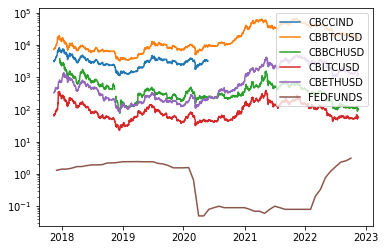

In [348]:
#transform data into lognormal and plot it 

plt.yscale('log') # first show linear


for ticker in macro_indicators:
    plt.plot(macro_indicators[ticker], label=ticker)

plt.legend(loc="upper right")

plt.show()

In [362]:
def log_return(prices):
  return np.log(prices / prices.shift(1))
  
returns1 = log_return(macro_indicators['CBCCIND'])
returns2 = log_return(macro_indicators['CBBTCUSD'])
returns3 = log_return(macro_indicators['CBBCHUSD'])
returns4 = log_return(macro_indicators['CBLTCUSD'])
returns5 = log_return(macro_indicators['CBETHUSD'])
returns6 = log_return(macro_indicators['FEDFUNDS'])



In [398]:
frames = [returns1, returns2, returns3, returns4, returns5, returns6]

frames

[             CBCCIND
 DATE                
 2017-11-15       NaN
 2017-11-16  0.070815
 2017-11-17 -0.031085
 2017-11-18  0.023628
 2017-11-19  0.035127
 ...              ...
 2020-05-22  0.016521
 2020-05-23  0.000609
 2020-05-24 -0.049604
 2020-05-25  0.021554
 2020-05-26 -0.007420
 
 [924 rows x 1 columns],
             CBBTCUSD
 DATE                
 2017-11-15       NaN
 2017-11-16  0.071999
 2017-11-17 -0.015922
 2017-11-18  0.008043
 2017-11-19  0.032239
 ...              ...
 2022-11-10  0.103164
 2022-11-11 -0.033327
 2022-11-12 -0.012993
 2022-11-13 -0.029463
 2022-11-14  0.017396
 
 [1826 rows x 1 columns],
             CBBCHUSD
 DATE                
 2017-12-20       NaN
 2017-12-21 -0.169540
 2017-12-22 -0.150744
 2017-12-23  0.149944
 2017-12-24 -0.079328
 ...              ...
 2022-11-10  0.146670
 2022-11-11  0.001462
 2022-11-12 -0.002535
 2022-11-13 -0.032946
 2022-11-14  0.043627
 
 [1791 rows x 1 columns],
             CBLTCUSD
 DATE                
 2017-11-15    